# ENSF 612 - ML to Identify Fake Calgary Hotel - Group 20
Drew Burritt  
Gregory Slowski  
Oluwajolasun Jaiyesimi  
Contributions: Names are listed in heading above each section  
### Note: Due to the nature of random split, some of the results in the notebook may be slightly different than shown in the report

# Preprocessing - Drew/Greg

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local[*]')
conf.set("spark.driver.memory", "12g") 
conf.set("spark.executor.memory", "6g") 
conf.set("spark.cores.max", "8")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
sc.stop()
a = sc._conf.get('spark.driver.memory')
print(a)

12g


In [3]:
#!pip install --upgrade pip
!pip install nltk
import nltk
nltk.download('punkt')
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DrewBurritt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#Drew
#Create UDF to tokenize words
def tokenize1(text):
    words = nltk.word_tokenize(text)
    return words  
tokenize_word = udf(lambda x: tokenize1(x)  , ArrayType(StringType()))

In [5]:
#Drew
#Create UDF to remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_en = stopwords.words('english')
def remove_stopwords1(word_list):
    filtered_words = [word for word in word_list if word not in stop_en]
    return filtered_words
remove_stopwords = udf(lambda x: remove_stopwords1(x) , ArrayType(StringType()))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DrewBurritt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DrewBurritt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#Drew
#Create UDF to remove noise
def remove_noise1(word_list):
    filtered_words = [word for word in word_list if word.isalnum() and len(word)>2]
    return filtered_words
remove_noise = udf(lambda x: remove_noise1(x) , ArrayType(StringType()))

In [7]:
#Drew
#Create UDF to stem words
from nltk.stem import SnowballStemmer
def stem1(word_list):
    snowball = SnowballStemmer(language='english')
    stemmed_words = [snowball.stem(word) for word in word_list]
    return stemmed_words
stem = udf(lambda x: stem1(x) , ArrayType(StringType()))

In [8]:
#Drew
#Create UDF to get sentiment score of review
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
def sentiment1(text):
  sia = SentimentIntensityAnalyzer()
  return sia.polarity_scores(text)['compound']
sentiment = udf(lambda x: sentiment1(x) , FloatType())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DrewBurritt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
#greg
#create udf for adding length of reviews by word count for all alphanumeric "words"

def get_length1(word_list):
  alphanum_words = [word for word in word_list if word.isalnum()]
  N = len(alphanum_words)
  return N

get_length = udf(lambda x: get_length1(x), IntegerType())

In [10]:
#greg
#create udf for adding average word length by review

def get_average_word_length1(word_list):
  alphanum_word_lengths = [len(word) for word in word_list if word.isalnum()]
  avg_word_len = sum(alphanum_word_lengths)/len(alphanum_word_lengths)
  return avg_word_len

get_average_word_length = udf(lambda x: get_average_word_length1(x), FloatType())

In [11]:
#greg
#create udf for ratio of capitalized characters to total characters (n), with no white spaces

def capital_ratio1(word_list):
  s = "".join(word_list)
  n = len(s)
  cap_n = len([char for char in s if char.isupper()])
  ratio_cap_to_total = cap_n / n
  return ratio_cap_to_total

capital_ratio = udf(lambda x: capital_ratio1(x), FloatType())

In [12]:
#greg
#create udf for ratio of long words (>5 letters) to total words (N)

def long_word_ratio1(word_list):
  alphanum_words = [word for word in word_list if word.isalnum()]
  N = len(alphanum_words)
  long_words = [word for word in alphanum_words if len(word) > 5]
  long_words_count = len(long_words)
  ratio_long_to_total = long_words_count / N
  return ratio_long_to_total

long_word_ratio = udf(lambda x: long_word_ratio1(x), FloatType())

In [13]:
#greg
#create udf for ratio of words after stop word removal vs total words

stop_en = stopwords.words('english')

def filtered_word_ratio1(word_list):
  alphanum_words = [word for word in word_list if word.isalnum()]
  N = len(alphanum_words)
  non_filtered_words = [word for word in alphanum_words if word not in stop_en]
  num_non_filtered_words = len(non_filtered_words)
  ratio_non_filtered_to_total = num_non_filtered_words / N
  return ratio_non_filtered_to_total

filtered_word_ratio = udf(lambda x: filtered_word_ratio1(x), FloatType())

In [14]:
#greg
#create udf for ratio of punctuation "words" vs total alphanumeric words

def punctuation_word_ratio1(word_list):
  alphanum_words = [word for word in word_list if word.isalnum()]
  N = len(alphanum_words)
  punctuation_words = [word for word in word_list if not(word.isalnum())]
  num_punctuation_words = len(punctuation_words)
  ratio_punctuation_to_total = num_punctuation_words / N
  return ratio_punctuation_to_total

punctuation_word_ratio = udf(lambda x: punctuation_word_ratio1(x), FloatType())

In [15]:
#Drew/Greg
from pyspark.sql.functions import lower
def process_data(df):
  dfText = df.select("Index","Review" ,"polarity","real_fake", tokenize_word("Review").alias("tokenized_words"))
  dfText = dfText.withColumn("sentiment" ,sentiment("Review"))
  dfText = dfText.withColumn("no_stopwords", remove_stopwords("tokenized_words"))
  dfText = dfText.withColumn("no_noise", remove_noise("no_stopwords"))
  dfText = dfText.withColumn("stemmed", stem("no_noise"))
  #dfText = dfText.select('*', F.concat_ws("_","real_fake","polarity").alias("target"))
  dfText = dfText.withColumn("length_in_words", get_length("tokenized_words"))
  dfText = dfText.withColumn("average_word_length", get_average_word_length("tokenized_words"))
  dfText = dfText.withColumn("capital_char_ratio", capital_ratio("tokenized_words"))
  dfText = dfText.withColumn("long_word_ratio", long_word_ratio("tokenized_words"))
  dfText = dfText.withColumn("non_stop_word_ratio", filtered_word_ratio("tokenized_words"))
  dfText = dfText.withColumn("punctuation_ratio", punctuation_word_ratio("tokenized_words"))

  return dfText

In [38]:
#Drew/Greg
df_raw_old = spark.read.option("escape","\"").option("header",True).csv("Original_data.csv")
df_old_all = process_data(df_raw_old)
#df_test = df_test_all.select("Review","stemmed","sentiment","target","real_fake")
df_old = df_old_all.select("Index","Review","stemmed","sentiment","polarity", "length_in_words", "average_word_length", \
                             "capital_char_ratio", "long_word_ratio", "non_stop_word_ratio", "punctuation_ratio", "real_fake")

old_train_split, old_test_split = df_old.randomSplit([0.80, 0.20], 1)
old_train_split.cache()
old_test_split.cache()

df_raw_new = spark.read.option("escape","\"").option("header",True).csv("Hotel_Reviews_Calgary.csv")
df_new_all = process_data(df_raw_new)
#df_train = df_train.select("Review","stemmed","sentiment","target","real_fake")
df_new = df_new_all.select("Index","Review","stemmed","sentiment","polarity", "length_in_words", "average_word_length", \
                             "capital_char_ratio", "long_word_ratio", "non_stop_word_ratio", "punctuation_ratio", "real_fake")

new_train_split, new_test_split = df_new.randomSplit([0.81, 0.20], 1)
new_train_split.cache()
new_test_split.cache()

#df_train.display()
combined_train = old_train_split.union(new_train_split)
combined_test = old_test_split.union(new_test_split)

combined_train.cache()
combined_test.cache()

DataFrame[Index: string, Review: string, stemmed: array<string>, sentiment: float, polarity: string, length_in_words: int, average_word_length: float, capital_char_ratio: float, long_word_ratio: float, non_stop_word_ratio: float, punctuation_ratio: float, real_fake: string]

In [87]:
print((new_train_split.count(), len(combined_test.columns)))
print((combined_test.count(), len(combined_test.columns)))

(794, 12)
(547, 12)


In [39]:
combined_train.show(1)

+-----+--------------------+--------------------+---------+--------+---------------+-------------------+------------------+---------------+-------------------+-----------------+---------+
|Index|              Review|             stemmed|sentiment|polarity|length_in_words|average_word_length|capital_char_ratio|long_word_ratio|non_stop_word_ratio|punctuation_ratio|real_fake|
+-----+--------------------+--------------------+---------+--------+---------------+-------------------+------------------+---------------+-------------------+-----------------+---------+
|    1|We stayed 2 night...|[stay, night, spr...|  -0.9593|negative|             66|          4.1060605|        0.04693141|     0.25757575|         0.59090906|       0.09090909|     real|
+-----+--------------------+--------------------+---------+--------+---------------+-------------------+------------------+---------------+-------------------+-----------------+---------+
only showing top 1 row



# Logistic Regression - Drew

In [18]:
#Drew

from pyspark.ml.feature import HashingTF, IDF, IndexToString, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

columns_to_be_scaled = ['length_in_words', 'average_word_length', 'capital_char_ratio', 'long_word_ratio', 'non_stop_word_ratio', 'punctuation_ratio']
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_be_scaled]
scalers  = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_be_scaled]
scaling_pipeline = Pipeline(stages=assemblers + scalers)

hashingTF = HashingTF(inputCol="stemmed", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="TF_IDF", minDocFreq=2)
label_strIdx1 = StringIndexer(inputCol="polarity", outputCol="polarity_idx")
assembles = VectorAssembler(inputCols = ['TF_IDF','sentiment','polarity_idx', 'length_in_words_scaled', 'average_word_length_scaled', 'capital_char_ratio_scaled', 'long_word_ratio_scaled', 'non_stop_word_ratio_scaled', 'punctuation_ratio_scaled'],outputCol="features")
label_strIdx2 = StringIndexer(inputCol="real_fake", outputCol="label")
lr = LogisticRegression(regParam = 0.3)
label_idxStr = IndexToString(inputCol = "label", outputCol = "article_class")

pipeline = Pipeline(stages=[scaling_pipeline, hashingTF, idf,label_strIdx1, assembles, label_strIdx2, lr ,label_idxStr])

In [19]:
#Drew
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10000,20000,50000]) \
    .addGrid(lr.regParam, [0.1, 0.3 ,0.5]) \
    .build()
crossval_lr = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid,evaluator= MulticlassClassificationEvaluator(),numFolds=5,parallelism = 100 )  # use 3+ folds in practice


In [68]:
cvModel_lr = crossval_lr.fit(combined_train)

In [69]:
pred_old_lr = cvModel_lr.transform(old_test_split)
pred_new_lr = cvModel_lr.transform(new_test_split)
pred_combined_lr = cvModel_lr.transform(combined_test)

pred_old_lr.cache()
pred_new_lr.cache()
pred_combined_lr.cache()

DataFrame[Index: string, Review: string, stemmed: array<string>, sentiment: float, polarity: string, length_in_words: int, average_word_length: float, capital_char_ratio: float, long_word_ratio: float, non_stop_word_ratio: float, punctuation_ratio: float, real_fake: string, length_in_words_vec: vector, average_word_length_vec: vector, capital_char_ratio_vec: vector, long_word_ratio_vec: vector, non_stop_word_ratio_vec: vector, punctuation_ratio_vec: vector, length_in_words_scaled: vector, average_word_length_scaled: vector, capital_char_ratio_scaled: vector, long_word_ratio_scaled: vector, non_stop_word_ratio_scaled: vector, punctuation_ratio_scaled: vector, rawFeatures: vector, TF_IDF: vector, polarity_idx: double, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double, article_class: string]

In [70]:
params = [{
      p.name: v
      for p,
      v in m.items()
   }
   for m in cvModel_lr.getEstimatorParamMaps()
]
import pandas as pd

pd.DataFrame.from_dict([{
      cvModel_lr.getEvaluator().getMetricName(): metric,
      ** ps
   }
   for ps, metric in zip(params, cvModel_lr.avgMetrics)
])

,f1,numFeatures,regParam
0,0.791431,10000,0.1
1,0.785407,10000,0.3
2,0.780055,10000,0.5
3,0.789159,20000,0.1
4,0.783702,20000,0.3
5,0.780651,20000,0.5
6,0.800504,50000,0.1
7,0.789846,50000,0.3
8,0.782900,50000,0.5


In [71]:
print("Best hashing number of features: ", cvModel_lr.bestModel.stages[1]._java_obj.getNumFeatures())
print("Best regularization parameter: ", cvModel_lr.bestModel.stages[6]._java_obj.getRegParam())

Best hashing number of features:  50000
Best regularization parameter:  0.1


In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
print("Logistic Regression")
eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
acc_our_data = eval.evaluate(pred_new_lr)
print("new data: ", acc_our_data)
acc_original_data = eval.evaluate(pred_old_lr)
print("old data: ", acc_original_data)
acc_original_data = eval.evaluate(pred_combined_lr)
print("combined data: ", acc_original_data)

eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
evalf1 = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="f1")
evalprecision = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedPrecision")
evalrecall = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedRecall")

acc_new_data = eval.evaluate(pred_new_lr)
print("new data accuracy: ", acc_new_data)
f1_new_data = evalf1.evaluate(pred_new_lr)
print("new data f1: ", f1_new_data)
prec_new_data = evalprecision.evaluate(pred_new_lr)
print("new data precision: ", prec_new_data)
rec_new_data = evalrecall.evaluate(pred_new_lr)
print("new data recall: ", rec_new_data)

acc_old_data = eval.evaluate(pred_old_lr)
print("old data: ", acc_old_data)
f1_old_data = evalf1.evaluate(pred_old_lr)
print("old data f1: ", f1_old_data)
prec_old_data = evalprecision.evaluate(pred_old_lr)
print("old data precision: ", prec_old_data)
rec_old_data = evalrecall.evaluate(pred_old_lr)
print("old data recall: ", rec_old_data)

acc_combined_data = eval.evaluate(pred_combined_lr)
print("combined data: ", acc_combined_data)
f1_combined_data = evalf1.evaluate(pred_combined_lr)
print("combined data f1: ", f1_combined_data)
prec_combined_data = evalprecision.evaluate(pred_combined_lr)
print("combined data precision: ", prec_combined_data)
rec_combined_data = evalrecall.evaluate(pred_combined_lr)
print("combined data recall: ", rec_combined_data)

Logistic Regression
new data:  0.7766990291262136
old data:  0.8563049853372434
combined data:  0.8263254113345521
new data accuracy:  0.7766990291262136
new data f1:  0.7498168897754367
new data precision:  0.7313915857605179
new data recall:  0.7766990291262136
old data:  0.8563049853372434
old data f1:  0.8562234001424587
old data precision:  0.8579280116193675
old data recall:  0.8563049853372434
combined data:  0.8263254113345521
combined data f1:  0.8236641191470369
combined data precision:  0.8253535150332125
combined data recall:  0.8263254113345522


In [73]:
#Drew 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    mat = confusion_matrix(y_actual, y_pred, labels=labels)
    labels = ['real','fake']
    sns.heatmap(mat, xticklabels=labels,  yticklabels=labels, square=True, annot=True, cbar=False,fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

In [74]:
pred_new_lr = pred_new_lr.toPandas()
pred_old_lr = pred_old_lr.toPandas()
pred_combined_lr = pred_combined_lr.toPandas()

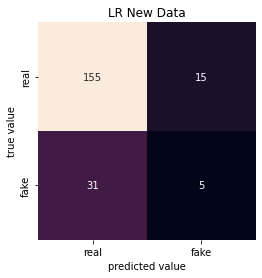

In [75]:
plot_confusion_matrix(pred_new_lr['label'], pred_new_lr['prediction'], labels=[0,1], title = "LR New Data")

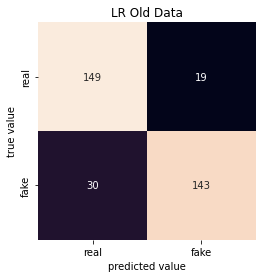

In [76]:
plot_confusion_matrix(pred_old_lr['label'], pred_old_lr['prediction'], labels=[0,1],title = "LR Old Data")

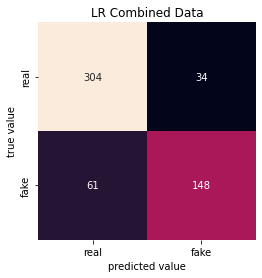

In [77]:
plot_confusion_matrix(pred_combined_lr['label'], pred_combined_lr['prediction'], labels=[0,1],title = "LR Combined Data")

# SVC - Drew

In [73]:
#Drew

from pyspark.ml.feature import HashingTF, IDF, IndexToString, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

columns_to_be_scaled = ['length_in_words', 'average_word_length', 'capital_char_ratio', 'long_word_ratio', 'non_stop_word_ratio', 'punctuation_ratio']
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_be_scaled]
scalers  = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_be_scaled]
scaling_pipeline = Pipeline(stages=assemblers + scalers)

hashingTF = HashingTF(inputCol="stemmed", outputCol="rawFeatures", numFeatures=20000)
idf = IDF(inputCol="rawFeatures", outputCol="TF_IDF", minDocFreq=2)
label_strIdx1 = StringIndexer(inputCol="polarity", outputCol="polarity_idx")
assembles = VectorAssembler(inputCols = ['TF_IDF','sentiment','polarity_idx', 'length_in_words_scaled', 'average_word_length_scaled', 'capital_char_ratio_scaled', 'long_word_ratio_scaled', 'non_stop_word_ratio_scaled', 'punctuation_ratio_scaled'],outputCol="features")
label_strIdx2 = StringIndexer(inputCol="real_fake", outputCol="label")
svc = LinearSVC(featuresCol="features",labelCol="label")
label_idxStr = IndexToString(inputCol = "label", outputCol = "article_class")

pipeline_svc = Pipeline(stages=[scaling_pipeline, hashingTF, idf,label_strIdx1, assembles, label_strIdx2, svc ,label_idxStr])

In [74]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10000,20000,50000]) \
    .addGrid(svc.regParam, [0.001, 0.01, 0.01, 1.0]) \
    .build()
crossval_svc = CrossValidator(estimator=pipeline_svc, estimatorParamMaps=paramGrid,evaluator= MulticlassClassificationEvaluator(),numFolds=5,parallelism = 100 )  # use 3+ folds in practice

In [75]:
cvModel_svc = crossval_svc.fit(combined_train)

In [76]:
pred_old_svc = cvModel_svc.transform(old_test_split)
pred_new_svc = cvModel_svc.transform(new_test_split)
pred_combined_svc = cvModel_svc.transform(combined_test)

pred_old_svc.cache()
pred_new_svc.cache()
pred_combined_svc.cache()

DataFrame[Index: string, Review: string, stemmed: array<string>, sentiment: float, polarity: string, length_in_words: int, average_word_length: float, capital_char_ratio: float, long_word_ratio: float, non_stop_word_ratio: float, punctuation_ratio: float, real_fake: string, length_in_words_vec: vector, average_word_length_vec: vector, capital_char_ratio_vec: vector, long_word_ratio_vec: vector, non_stop_word_ratio_vec: vector, punctuation_ratio_vec: vector, length_in_words_scaled: vector, average_word_length_scaled: vector, capital_char_ratio_scaled: vector, long_word_ratio_scaled: vector, non_stop_word_ratio_scaled: vector, punctuation_ratio_scaled: vector, rawFeatures: vector, TF_IDF: vector, polarity_idx: double, features: vector, label: double, rawPrediction: vector, prediction: double, article_class: string]

In [77]:
params = [{
      p.name: v
      for p,
      v in m.items()
   }
   for m in cvModel_svc.getEstimatorParamMaps()
]
import pandas as pd

pd.DataFrame.from_dict([{
      cvModel_svc.getEvaluator().getMetricName(): metric,
      ** ps
   }
   for ps, metric in zip(params, cvModel_svc.avgMetrics)
])

,f1,numFeatures,regParam
0,0.764708,10000,0.001
1,0.771835,10000,0.010
2,0.771835,10000,0.010
3,0.776334,10000,1.000
4,0.759178,20000,0.001
5,0.765598,20000,0.010
6,0.765598,20000,0.010
7,0.769944,20000,1.000
8,0.764153,50000,0.001
9,0.766673,50000,0.010


In [78]:
print("Best hashing number of features: ", cvModel_svc.bestModel.stages[1]._java_obj.getNumFeatures())
print("Best regularization parameter: ", cvModel_svc.bestModel.stages[6]._java_obj.getRegParam())

Best hashing number of features:  10000
Best regularization parameter:  1.0


In [79]:
print("SVC")
eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
acc_new_data = eval.evaluate(pred_new_svc)
print("new data: ", acc_new_data)
acc_old_data = eval.evaluate(pred_old_svc)
print("old data: ", acc_old_data)
acc_combined_data = eval.evaluate(pred_combined_svc)
print("combined data: ", acc_combined_data)

eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
evalf1 = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="f1")
evalprecision = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedPrecision")
evalrecall = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedRecall")

acc_new_data = eval.evaluate(pred_new_svc)
print("new data accuracy: ", acc_new_data)
f1_new_data = evalf1.evaluate(pred_new_svc)
print("new data f1: ", f1_new_data)
prec_new_data = evalprecision.evaluate(pred_new_svc)
print("new data precision: ", prec_new_data)
rec_new_data = evalrecall.evaluate(pred_new_svc)
print("new data recall: ", rec_new_data)

acc_old_data = eval.evaluate(pred_old_svc)
print("old data: ", acc_old_data)
f1_old_data = evalf1.evaluate(pred_old_svc)
print("old data f1: ", f1_old_data)
prec_old_data = evalprecision.evaluate(pred_old_svc)
print("old data precision: ", prec_old_data)
rec_old_data = evalrecall.evaluate(pred_old_svc)
print("old data recall: ", rec_old_data)

acc_combined_data = eval.evaluate(pred_combined_svc)
print("combined data: ", acc_combined_data)
f1_combined_data = evalf1.evaluate(pred_combined_svc)
print("combined data f1: ", f1_combined_data)
prec_combined_data = evalprecision.evaluate(pred_combined_svc)
print("combined data precision: ", prec_combined_data)
rec_combined_data = evalrecall.evaluate(pred_combined_svc)
print("combined data recall: ", rec_combined_data)

SVC
new data:  0.8058252427184466
old data:  0.8240469208211144
combined data:  0.8171846435100548
new data accuracy:  0.8058252427184466
new data f1:  0.7443490647374142
new data precision:  0.7099514563106796
new data recall:  0.8058252427184466
old data:  0.8240469208211144
old data f1:  0.8237803252466009
old data precision:  0.827162198268406
old data recall:  0.8240469208211143
combined data:  0.8171846435100548
combined data f1:  0.8117053014057447
combined data precision:  0.8192416083452032
combined data recall:  0.8171846435100548


In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    mat = confusion_matrix(y_actual, y_pred, labels=labels)
    labels = ['real','fake']
    sns.heatmap(mat, xticklabels=labels,  yticklabels=labels, square=True, annot=True, cbar=False,fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

In [81]:
pred_new_svc = pred_new_svc.toPandas()
pred_old_svc = pred_old_svc.toPandas()
pred_combined_svc = pred_combined_svc.toPandas()

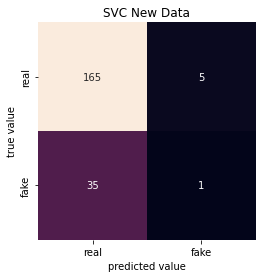

In [82]:
plot_confusion_matrix(pred_new_svc['label'], pred_new_svc['prediction'], labels=[0,1], title = "SVC New Data")

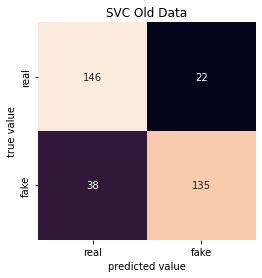

In [83]:
plot_confusion_matrix(pred_old_svc['label'], pred_old_svc['prediction'], labels=[0,1], title = "SVC Old Data")

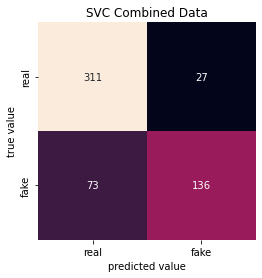

In [84]:
plot_confusion_matrix(pred_combined_svc['label'], pred_combined_svc['prediction'], labels=[0,1], title = "SVC Combined Data")

# Random Forest Classifier - Greg

In [19]:
#greg

from pyspark.ml.feature import HashingTF, IDF, IndexToString, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

columns_to_be_scaled = ['length_in_words', 'average_word_length', 'capital_char_ratio', 'long_word_ratio', 'non_stop_word_ratio', 'punctuation_ratio']
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_be_scaled]
scalers  = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_be_scaled]
scaling_pipeline = Pipeline(stages=assemblers + scalers)

hashingTF = HashingTF(inputCol="stemmed", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="TF_IDF", minDocFreq=2)
label_strIdx1 = StringIndexer(inputCol="polarity", outputCol="polarity_idx")
assembles = VectorAssembler(inputCols = ['TF_IDF','sentiment','polarity_idx', 'length_in_words_scaled', 'average_word_length_scaled', 'capital_char_ratio_scaled', 'long_word_ratio_scaled', 'non_stop_word_ratio_scaled', 'punctuation_ratio_scaled'],outputCol="features")
label_strIdx2 = StringIndexer(inputCol="real_fake", outputCol="label")
rfc = RandomForestClassifier(featuresCol="features",labelCol="label")
label_idxStr = IndexToString(inputCol = "label", outputCol = "article_class")

pipeline_rfc = Pipeline(stages=[scaling_pipeline, hashingTF, idf,label_strIdx1 , assembles, label_strIdx2, rfc ,label_idxStr])

In [20]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10000,20000,50000]) \
    .addGrid(rfc.maxDepth, [3, 5, 9]) \
    .addGrid(rfc.numTrees, [10, 20, 50]) \
    .build()
crossval_rfc = CrossValidator(estimator=pipeline_rfc, estimatorParamMaps=paramGrid,evaluator= MulticlassClassificationEvaluator(),numFolds=5,parallelism = 100 )  # use 3+ folds in practice

In [ ]:
cvModel_rfc = crossval_rfc.fit(combined_train)

In [26]:
pred_old_rfc = cvModel_rfc.transform(old_test_split)
pred_new_rfc = cvModel_rfc.transform(new_test_split)
pred_combined_rfc = cvModel_rfc.transform(combined_test)

pred_old_rfc.cache()
pred_new_rfc.cache()
pred_combined_rfc.cache()

DataFrame[Index: string, Review: string, stemmed: array<string>, sentiment: float, polarity: string, length_in_words: int, average_word_length: float, capital_char_ratio: float, long_word_ratio: float, non_stop_word_ratio: float, punctuation_ratio: float, real_fake: string, length_in_words_vec: vector, average_word_length_vec: vector, capital_char_ratio_vec: vector, long_word_ratio_vec: vector, non_stop_word_ratio_vec: vector, punctuation_ratio_vec: vector, length_in_words_scaled: vector, average_word_length_scaled: vector, capital_char_ratio_scaled: vector, long_word_ratio_scaled: vector, non_stop_word_ratio_scaled: vector, punctuation_ratio_scaled: vector, rawFeatures: vector, TF_IDF: vector, polarity_idx: double, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double, article_class: string]

In [27]:
params = [{
      p.name: v
      for p,
      v in m.items()
   }
   for m in cvModel_rfc.getEstimatorParamMaps()
]
import pandas as pd

pd.DataFrame.from_dict([{
      cvModel_rfc.getEvaluator().getMetricName(): metric,
      ** ps
   } for ps, metric in zip(params, cvModel_rfc.avgMetrics)
])

,f1,numFeatures,maxDepth,numTrees
0,0.480488,10000,3,10
1,0.479452,10000,3,20
2,0.476418,10000,3,50
3,0.507955,10000,5,10
4,0.491458,10000,5,20
5,0.494541,10000,5,50
6,0.584245,10000,9,10
7,0.572209,10000,9,20
8,0.568334,10000,9,50
9,0.487361,20000,3,10


In [28]:
print("Best hashing number of features: ", cvModel_rfc.bestModel.stages[1]._java_obj.getNumFeatures())
print("Best max depth parameter: ", cvModel_rfc.bestModel.stages[6]._java_obj.getMaxDepth())
print("Best numTrees parameter: ", cvModel_rfc.bestModel.stages[6]._java_obj.getNumTrees())

Best hashing number of features:  10000
Best max depth parameter:  9
Best numTrees parameter:  10


In [29]:
print("Random Forest")
eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
acc_new_data = eval.evaluate(pred_new_rfc)
print("new data: ", acc_new_data)
acc_old_data = eval.evaluate(pred_old_rfc)
print("old data: ", acc_old_data)
acc_combined_data = eval.evaluate(pred_combined_rfc)
print("combined data: ", acc_combined_data)

eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
evalf1 = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="f1")
evalprecision = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedPrecision")
evalrecall = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedRecall")

acc_new_data = eval.evaluate(pred_new_rfc)
print("new data accuracy: ", acc_new_data)
f1_new_data = evalf1.evaluate(pred_new_rfc)
print("new data f1: ", f1_new_data)
prec_new_data = evalprecision.evaluate(pred_new_rfc)
print("new data precision: ", prec_new_data)
rec_new_data = evalrecall.evaluate(pred_new_rfc)
print("new data recall: ", rec_new_data)

acc_old_data = eval.evaluate(pred_old_rfc)
print("old data: ", acc_old_data)
f1_old_data = evalf1.evaluate(pred_old_rfc)
print("old data f1: ", f1_old_data)
prec_old_data = evalprecision.evaluate(pred_old_rfc)
print("old data precision: ", prec_old_data)
rec_old_data = evalrecall.evaluate(pred_old_rfc)
print("old data recall: ", rec_old_data)

acc_combined_data = eval.evaluate(pred_combined_rfc)
print("combined data: ", acc_combined_data)
f1_combined_data = evalf1.evaluate(pred_combined_rfc)
print("combined data f1: ", f1_combined_data)
prec_combined_data = evalprecision.evaluate(pred_combined_rfc)
print("combined data precision: ", prec_combined_data)
rec_combined_data = evalrecall.evaluate(pred_combined_rfc)
print("combined data recall: ", rec_combined_data)

Random Forest
new data:  0.8252427184466019
old data:  0.5982404692082112
combined data:  0.6837294332723949
new data accuracy:  0.8252427184466019
new data f1:  0.7462301177442676
new data precision:  0.6810255443491375
new data recall:  0.8252427184466019
old data:  0.5982404692082112
old data f1:  0.545471240426477
old data precision:  0.6957179982357009
old data recall:  0.5982404692082111
combined data:  0.6837294332723949
combined data f1:  0.6200275836187676
combined data precision:  0.7307651422165033
combined data recall:  0.6837294332723949


In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    mat = confusion_matrix(y_actual, y_pred, labels=labels)
    labels = ['real','fake']
    sns.heatmap(mat, xticklabels=labels,  yticklabels=labels, square=True, annot=True, cbar=False,fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

In [31]:
pred_new_rfc = pred_new_rfc.toPandas()
pred_old_rfc = pred_old_rfc.toPandas()
pred_combined_rfc = pred_combined_rfc.toPandas()

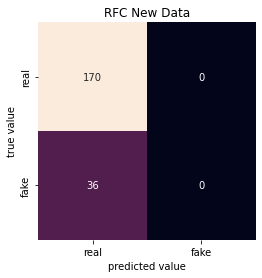

In [32]:
plot_confusion_matrix(pred_new_rfc['label'], pred_new_rfc['prediction'], labels=[0,1],title = "RFC New Data")

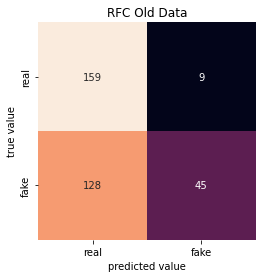

In [33]:
plot_confusion_matrix(pred_old_rfc['label'], pred_old_rfc['prediction'], labels=[0,1],title = "RFC Old Data")

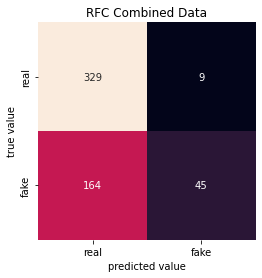

In [34]:
plot_confusion_matrix(pred_combined_rfc['label'], pred_combined_rfc['prediction'], labels=[0,1],title = "RFC Combined Data")

# Gradient Boosting Classifier - Greg
#### See report, after initial testing it was decided to not continue with gradient boosting due to the very long run time and poor performance in random forest

In [ ]:
# # #greg

# from pyspark.ml.feature import HashingTF, IDF, IndexToString, StringIndexer
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StandardScaler
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.classification import LinearSVC
# from pyspark.ml.classification import NaiveBayes
# from pyspark.ml.classification import GBTClassifier
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# columns_to_be_scaled = ['length_in_words', 'average_word_length', 'capital_char_ratio', 'long_word_ratio', 'non_stop_word_ratio', 'punctuation_ratio']
# assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_be_scaled]
# scalers  = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_be_scaled]
# scaling_pipeline = Pipeline(stages=assemblers + scalers)

# hashingTF = HashingTF(inputCol="stemmed", outputCol="rawFeatures")
# idf = IDF(inputCol="rawFeatures", outputCol="TF_IDF", minDocFreq=2)
# label_strIdx1 = StringIndexer(inputCol="polarity", outputCol="polarity_idx")
# assembles = VectorAssembler(inputCols = ['TF_IDF','sentiment','polarity_idx', 'length_in_words_scaled', 'average_word_length_scaled', 'capital_char_ratio_scaled', 'long_word_ratio_scaled', 'non_stop_word_ratio_scaled', 'punctuation_ratio_scaled'],outputCol="features")
# label_strIdx2 = StringIndexer(inputCol="real_fake", outputCol="label")
# gbtc = GBTClassifier(featuresCol="features",labelCol="label")
# label_idxStr = IndexToString(inputCol = "label", outputCol = "article_class")

# pipeline_gbtc = Pipeline(stages=[scaling_pipeline, hashingTF, idf,label_strIdx1 , assembles, label_strIdx2, gbtc ,label_idxStr])

In [ ]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# paramGrid = ParamGridBuilder() \
#     .addGrid(hashingTF.numFeatures, [10000,16384,32768]) \
#     .addGrid(gbtc.maxDepth, [3, 5, 7]) \
#     .addGrid(gbtc.stepSize, [0.1, 0.5, 1.0]) \
#     .build()
# crossval_gbtc = CrossValidator(estimator=pipeline_gbtc, estimatorParamMaps=paramGrid,evaluator= MulticlassClassificationEvaluator(),numFolds=2,parallelism = 100 )  # use 3+ folds in practice

In [ ]:
#cvModel_gbtc = pipeline_gbtc.fit(combined_train)
#cvModel_gbtc = crossval_gbtc.fit(combined_train)

In [ ]:
# pred_old_gbtc = cvModel_gbtc.transform(old_test_split)
# pred_new_gbtc = cvModel_gbtc.transform(new_test_split)
# pred_combined_gbtc = cvModel_gbtc.transform(combined_test)

# pred_old_gbtc.cache()
# pred_new_gbtc.cache()
# pred_combined_gbtc.cache()

In [ ]:
# eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
# acc_new_data = eval.evaluate(pred_new_gbtc)
# print("new data: ", acc_new_data)
# acc_old_data = eval.evaluate(pred_old_gbtc)
# print("old data: ", acc_old_data)
# acc_combined_data = eval.evaluate(pred_combined_gbtc)
# print("combined data: ", acc_combined_data)

In [ ]:
# params = [{
#       p.name: v
#       for p,
#       v in m.items()
#    }
#    for m in cvModel_gbtc.getEstimatorParamMaps()
# ]
# import pandas as pd

# pd.DataFrame.from_dict([{
#       cvModel_gbtc.getEvaluator().getMetricName(): metric,
#       ** ps
#    } for ps, metric in zip(params, cvModel_gbtc.avgMetrics)
# ])

In [ ]:
# print("Best regularization parameter: ", cvModel_gbtc.bestModel.stages[6]._java_obj.getRegParam())
# print("Best hashing number of features: ", cvModel_gbtc.bestModel.stages[1]._java_obj.getNumFeatures())

# Logistic Regression Tuning Best Params - Oluwajolasun 

In [35]:
from pyspark.ml.feature import HashingTF, IDF, IndexToString, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

columns_to_be_scaled = ['length_in_words', 'average_word_length', 'capital_char_ratio', 'long_word_ratio', 'non_stop_word_ratio', 'punctuation_ratio']
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_be_scaled]
scalers  = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_be_scaled]
scaling_pipeline = Pipeline(stages=assemblers + scalers)

hashingTF = HashingTF(inputCol="stemmed", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="TF_IDF", minDocFreq=2)
label_strIdx1 = StringIndexer(inputCol="polarity", outputCol="polarity_idx")
assembles = VectorAssembler(inputCols = ['TF_IDF','sentiment','polarity_idx', 'length_in_words_scaled', 'average_word_length_scaled', 'capital_char_ratio_scaled', 'long_word_ratio_scaled', 'non_stop_word_ratio_scaled', 'punctuation_ratio_scaled'],outputCol="features")
label_strIdx2 = StringIndexer(inputCol="real_fake", outputCol="label")
lr = LogisticRegression()
label_idxStr = IndexToString(inputCol = "label", outputCol = "article_class")

pipeline = Pipeline(stages=[scaling_pipeline, hashingTF, idf,label_strIdx1, assembles, label_strIdx2, lr ,label_idxStr])

In [36]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [5000,10000,20000,30000,50000]) \
    .addGrid(lr.regParam, [0.0, 0.1, 0.3, 0.5]) \
    .addGrid(lr.standardization,[True,False]) \
    .build()
crossval_lr = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid,evaluator= MulticlassClassificationEvaluator(),numFolds=5,parallelism = 100)  # use 3+ folds in practice

In [59]:
cvModel_lr = crossval_lr.fit(combined_train)

In [60]:
params = [{
      p.name: v
      for p,
      v in m.items()
   }
   for m in cvModel_lr.getEstimatorParamMaps()
]
import pandas as pd

pd.DataFrame.from_dict([{
      cvModel_lr.getEvaluator().getMetricName(): metric,
      ** ps
   }
   for ps, metric in zip(params, cvModel_lr.avgMetrics)
])

,f1,numFeatures,regParam,standardization
0,0.755115,5000,0.0,True
1,0.755115,5000,0.0,False
2,0.797848,5000,0.1,True
3,0.812191,5000,0.1,False
4,0.791091,5000,0.3,True
5,0.802436,5000,0.3,False
6,0.784227,5000,0.5,True
7,0.773065,5000,0.5,False
8,0.757075,10000,0.0,True
9,0.757075,10000,0.0,False


In [40]:
print("Best hashing number of features: ", cvModel_lr.bestModel.stages[1]._java_obj.getNumFeatures())
print("Best regularization parameter: ", cvModel_lr.bestModel.stages[6]._java_obj.getRegParam())
print("Best Standardization parameter: ", cvModel_lr.bestModel.stages[6]._java_obj.getStandardization())


Best hashing number of features:  10000
Best regularization parameter:  0.1
Best Standardization parameter:  False


In [41]:
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [30000]) \
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.standardization, [False]) \
    .build()
crossval_lr = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator = MulticlassClassificationEvaluator(), numFolds=5, parallelism = 100 )

In [42]:
cvModel_lr = crossval_lr.fit(combined_train)

In [43]:
pred_old_lr = cvModel_lr.transform(old_test_split)
pred_new_lr = cvModel_lr.transform(new_test_split)
pred_combined_lr = cvModel_lr.transform(combined_test)

pred_old_lr.cache()
pred_new_lr.cache()
pred_combined_lr.cache()

DataFrame[Index: string, Review: string, stemmed: array<string>, sentiment: float, polarity: string, length_in_words: int, average_word_length: float, capital_char_ratio: float, long_word_ratio: float, non_stop_word_ratio: float, punctuation_ratio: float, real_fake: string, length_in_words_vec: vector, average_word_length_vec: vector, capital_char_ratio_vec: vector, long_word_ratio_vec: vector, non_stop_word_ratio_vec: vector, punctuation_ratio_vec: vector, length_in_words_scaled: vector, average_word_length_scaled: vector, capital_char_ratio_scaled: vector, long_word_ratio_scaled: vector, non_stop_word_ratio_scaled: vector, punctuation_ratio_scaled: vector, rawFeatures: vector, TF_IDF: vector, polarity_idx: double, features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double, article_class: string]

In [58]:
params = [{
      p.name: v
      for p,
      v in m.items()
   }
   for m in cvModel_lr.getEstimatorParamMaps()
]
import pandas as pd
 
pd.DataFrame.from_dict([{
      cvModel_lr.getEvaluator().getMetricName(): metric,
      ** ps
   }
   for ps, metric in zip(params, cvModel_lr.avgMetrics)
])

,f1,numFeatures,regParam,standardization
0,0.812454,30000,0.1,False


In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
acc_our_data = eval.evaluate(pred_new_lr)
print("our data: ", acc_our_data)
acc_original_data = eval.evaluate(pred_old_lr)
print("original data: ", acc_original_data)
acc_original_data = eval.evaluate(pred_combined_lr)
print("combined data: ", acc_original_data)

eval = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")
evalf1 = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="f1")
evalprecision = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedPrecision")
evalrecall = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="weightedRecall")

acc_new_data = eval.evaluate(pred_new_lr)
print("new data accuracy: ", acc_new_data)
f1_new_data = evalf1.evaluate(pred_new_lr)
print("new data f1: ", f1_new_data)
prec_new_data = evalprecision.evaluate(pred_new_lr)
print("new data precision: ", prec_new_data)
rec_new_data = evalrecall.evaluate(pred_new_lr)
print("new data recall: ", rec_new_data)

acc_old_data = eval.evaluate(pred_old_lr)
print("old data: ", acc_old_data)
f1_old_data = evalf1.evaluate(pred_old_lr)
print("old data f1: ", f1_old_data)
prec_old_data = evalprecision.evaluate(pred_old_lr)
print("old data precision: ", prec_old_data)
rec_old_data = evalrecall.evaluate(pred_old_lr)
print("old data recall: ", rec_old_data)

acc_combined_data = eval.evaluate(pred_combined_lr)
print("combined data: ", acc_combined_data)
f1_combined_data = evalf1.evaluate(pred_combined_lr)
print("combined data f1: ", f1_combined_data)
prec_combined_data = evalprecision.evaluate(pred_combined_lr)
print("combined data precision: ", prec_combined_data)
rec_combined_data = evalrecall.evaluate(pred_combined_lr)
print("combined data recall: ", rec_combined_data)

our data:  0.7815533980582524
original data:  0.873900293255132
combined data:  0.8391224862888482
new data accuracy:  0.7815533980582524
new data f1:  0.730936945553534
new data precision:  0.6930092561160522
new data recall:  0.7815533980582524
old data:  0.873900293255132
old data f1:  0.8739002932551319
old data precision:  0.8742761449502079
old data recall:  0.873900293255132
combined data:  0.8391224862888482
combined data f1:  0.8363210722661774
combined data precision:  0.8390300683970109
combined data recall:  0.8391224862888482


In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    mat = confusion_matrix(y_actual, y_pred, labels=labels)
    labels = ['real','fake']
    sns.heatmap(mat, xticklabels=labels,  yticklabels=labels, square=True, annot=True, cbar=False,fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

In [47]:
pred_new_lr_pd = pred_new_lr.toPandas()
pred_old_lr_pd = pred_old_lr.toPandas()
pred_combined_lr_pd = pred_combined_lr.toPandas()

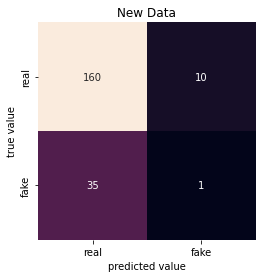

In [48]:
plot_confusion_matrix(pred_new_lr_pd['label'], pred_new_lr_pd['prediction'], labels=[0,1], title = "New Data")

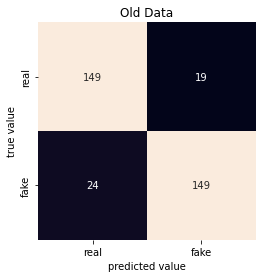

In [49]:
plot_confusion_matrix(pred_old_lr_pd['label'], pred_old_lr_pd['prediction'], labels=[0,1],title = "Old Data")

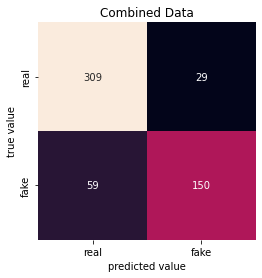

In [50]:
plot_confusion_matrix(pred_combined_lr_pd['label'], pred_combined_lr_pd['prediction'], labels=[0,1],title = "Combined Data")

In [53]:
from pyspark.sql.functions import col
from pyspark.ml.feature import IndexToString

mislabeled_lr = pred_combined_lr.select('Index','Review', 'polarity', 'real_fake', 'prediction').filter(col("label") != col("prediction"))

i2s = IndexToString(inputCol="prediction", outputCol="prediction string", labels=["real", "fake"])

mislabeled_lr_string = i2s.transform(mislabeled_lr).drop("prediction").withColumnRenamed("real_fake","True Label").withColumnRenamed("prediction string","Predicted Label")
mislabeled_lr_string.toPandas().to_csv('Final Submission/mislabelled_index.csv', index=False)
mislabeled_lr_string.show()

correct_lr = pred_combined_lr.select('Index','Review', 'polarity', 'real_fake', 'prediction').filter(col("label") == col("prediction"))

i2s = IndexToString(inputCol="prediction", outputCol="prediction string", labels=["real", "fake"])

correct_lr_string = i2s.transform(correct_lr).drop("prediction").withColumnRenamed("real_fake","True Label").withColumnRenamed("prediction string","Predicted Label")
correct_lr_string.cache()
correct_lr_string.show()
correct_lr_string.toPandas().to_csv("Final Submission/correct.csv", index=False)

+-----+--------------------+--------+----------+---------------+
|Index|              Review|polarity|True Label|Predicted Label|
+-----+--------------------+--------+----------+---------------+
| 1126|My Stay at Sherat...|positive|      fake|           real|
| 1160|My stay at the So...|positive|      fake|           real|
| 1162|The Swissotel Chi...|positive|      fake|           real|
| 1216|The recently remo...|positive|      real|           fake|
|  126|Great building an...|negative|      real|           fake|
| 1265|Recently returned...|positive|      real|           fake|
| 1286|My husband and I ...|positive|      real|           fake|
|  130|This morning, I c...|negative|      real|           fake|
|  131|I had purchased t...|negative|      real|           fake|
| 1340|my husband and l ...|positive|      real|           fake|
| 1428|We have just retu...|positive|      real|           fake|
| 1506|My wife and I red...|positive|      real|           fake|
|  153|I recently stayed.